# Author: Paulius Lapienis
# Social media analytics lab 2

# Step 1: Data reading and cleaning

In [8]:
import pandas as pd
from social_media_analytics.configs import DATA_DIR
import networkx as nx

df = pd.read_csv(DATA_DIR / "github-organizations.csv")
df = df[df["Organisation"] != "None"]
df = df[df["member"] != "None"].dropna()
G = nx.Graph()

for index, row in df.iterrows():
    G.add_edge(row["Organisation"], row["member"])

In [9]:
df.shape

(9652, 2)

# Step 2: Describing node parameters

### Degrees
The degree of a node in a network signifies the number of connections it has to other nodes. In the context of social networks, it can represent the number of relationships or interactions an entity (individual or organization) has within the network. Analyzing node degrees can help identify the most connected entities, which might indicate influential or central actors in the network.

In the following code cell, we will calculate and analyze the degrees of nodes in our network. We will identify nodes with the highest degrees, which could be interpreted as entities with the most connections or interactions within the network. Because of the size of the network, (9652 edges) matplotlib is used for visualization. Because of the skewedness (organizations have a lot of members, but members have only a few organizations) a log type axis is displayed.

The graph shows that most nodes have only a few connections while a few nodes have a lot of connections. This means that this is likely a one to many type relationship graph where we have a few nodes (organizations) that are connected to a lot of other nodes (people).

Average degree: 2.16
Node with maximum degree: microsoft (Degree: 3916)


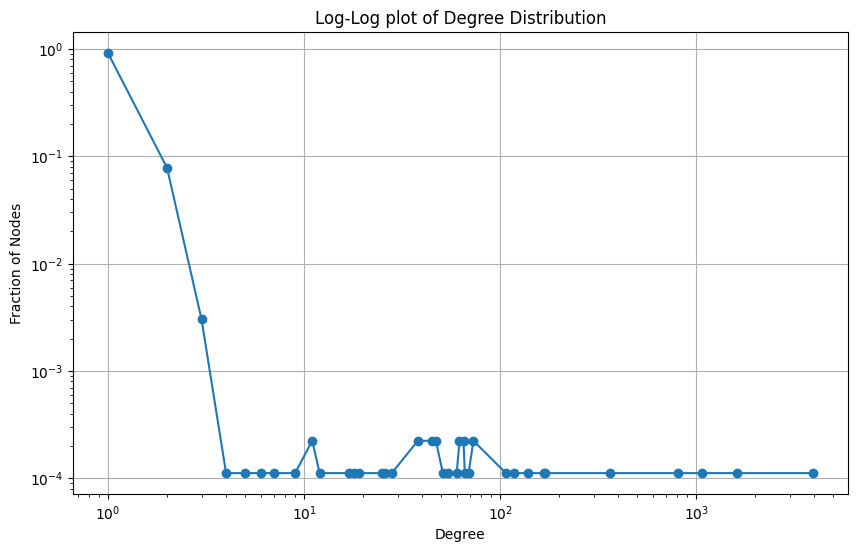

In [13]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Calculate degrees
degrees = dict(G.degree())

# Display basic degree stats
avg_degree = sum(degrees.values()) / len(degrees)
max_degree_node = max(degrees, key=degrees.get)
max_degree_value = degrees[max_degree_node]

print(f"Average degree: {avg_degree:.2f}")
print(f"Node with maximum degree: {max_degree_node} (Degree: {max_degree_value})")

# Calculate the degree distribution
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

# Create a log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(degree_values, histogram, 'o-')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.title('Log-Log plot of Degree Distribution')
plt.grid(True)
plt.show()

### Distance Matrix

In the realm of social network analysis, especially in networks like ours, which consist of a few organizations connecting to numerous individuals, the distance matrix can reveal intriguing insights about connectivity and information flow within the network. The organizations, being hubs connecting to multiple individuals, likely serve as pivotal connectors or bridges within the network, potentially minimizing the average path length across the entire network.

The distance matrix in a graph, where each entry `(i, j)` represents the shortest path length from node `i` to node `j`, becomes particularly insightful. In our context:
- **Organizations (Hubs)**: These nodes, due to their high-degree nature, might exhibit smaller average path lengths to other nodes, indicating their capability to rapidly disseminate information across the network.
- **Individuals**: These nodes might exhibit larger path lengths when connected to other individuals, indicating potential bottlenecks or slower information flow among them without the mediating role of organizations.

Analyzing the distance matrix allows us to:
- **Identify Influencers**: Nodes that consistently exhibit shorter path lengths might be crucial in information dissemination or influence spread.
- **Detect Community Structures**: Clusters or communities might be visible as blocks of nodes with smaller internal path lengths.
- **Understand Information Flow**: The average path length and distribution of path lengths can indicate how efficiently information might spread across the network.

In the following code cell, we will compute and visualize the distance matrix, providing a heatmap representation to intuitively understand the pairwise shortest path lengths and potentially uncover underlying patterns related to connectivity and information dissemination within the network.

In the matrix large dark rectangles can be seen. This means these individuals are connected to the same organization (the largest of these being microsoft).

The smaller green rectangles show individuals who are connected to smaller organizations, where the path from one smaller organization to another might be long since there is less of a chance of interlap with a bigger connecting organization (Hub).


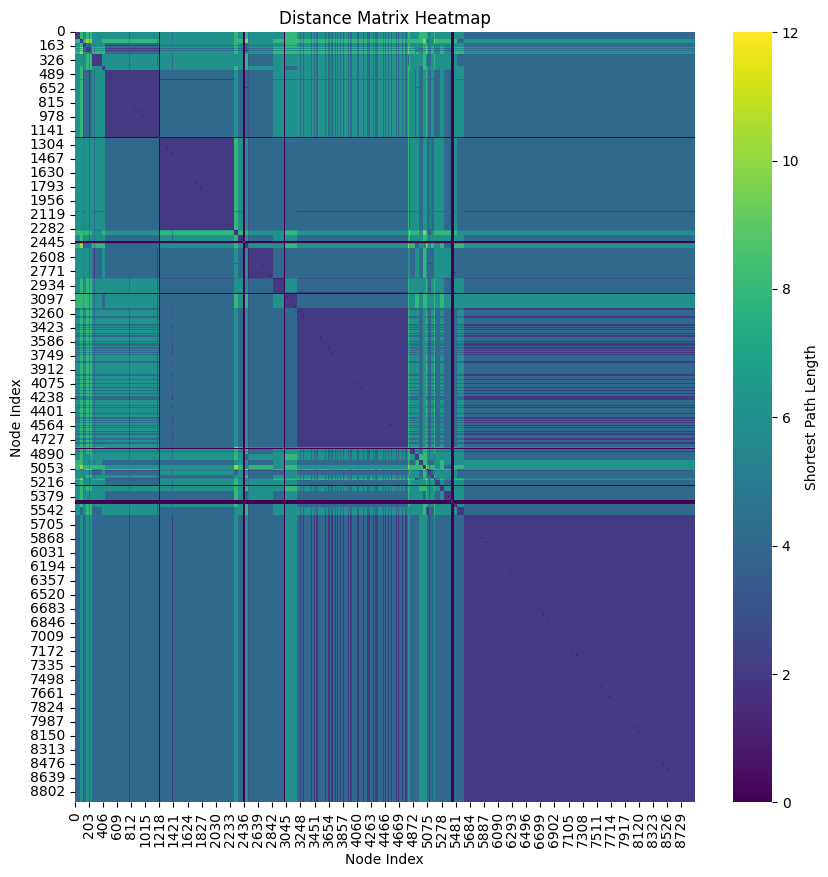

In [14]:
import seaborn as sns
import numpy as np

# Calculate the shortest path lengths between all pairs of nodes
path_length_dict = dict(nx.all_pairs_shortest_path_length(G))

# Convert the path lengths to a matrix format
num_nodes = len(G.nodes())
distance_matrix = np.zeros((num_nodes, num_nodes))

# Map nodes to indices for matrix representation
node_indices = {node: idx for idx, node in enumerate(G.nodes())}

# Populate the distance matrix
for node_a, lengths in path_length_dict.items():
    for node_b, length in lengths.items():
        distance_matrix[node_indices[node_a], node_indices[node_b]] = length

# Visualize the distance matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(distance_matrix, cmap='viridis', cbar_kws={'label': 'Shortest Path Length'})
plt.title('Distance Matrix Heatmap')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()


### Closeness

Closeness centrality is a measure that helps to identify nodes that can spread information efficiently through a graph. In the context of our network, which comprises a few organizations connected to numerous individuals, closeness centrality can provide insights into how accessible or distant nodes (both organizations and individuals) are within the network.

- **Organizations**: Given their high connectivity, organizations might exhibit higher closeness centrality, indicating their potential to quickly disseminate information to a larger portion of the network.
- **Individuals**: Depending on their connections, individuals might have varied closeness centrality, reflecting their relative accessibility or isolation within the network.

Analyzing closeness centrality allows us to:
- **Identify Key Disseminators**: Nodes with higher closeness can be crucial for faster information spread across the network.
- **Understand Accessibility**: Gain insights into how accessible or isolated certain nodes or groups of nodes are within the network.
- **Optimize Communication**: Strategize communication or intervention efforts by targeting nodes that can quickly reach larger network portions.

In the following code cell, we will calculate and analyze the closeness centrality of nodes in our network, aiming to identify key nodes and understand the overall accessibility and communication efficiency within the network.

A bump at 0.0 indicates isolated individuals. The gaps indicate that there might be separated communities connected by the same individuals.

Average closeness centrality: 0.26
Node with maximum closeness centrality: microsoft (Closeness: 0.44)


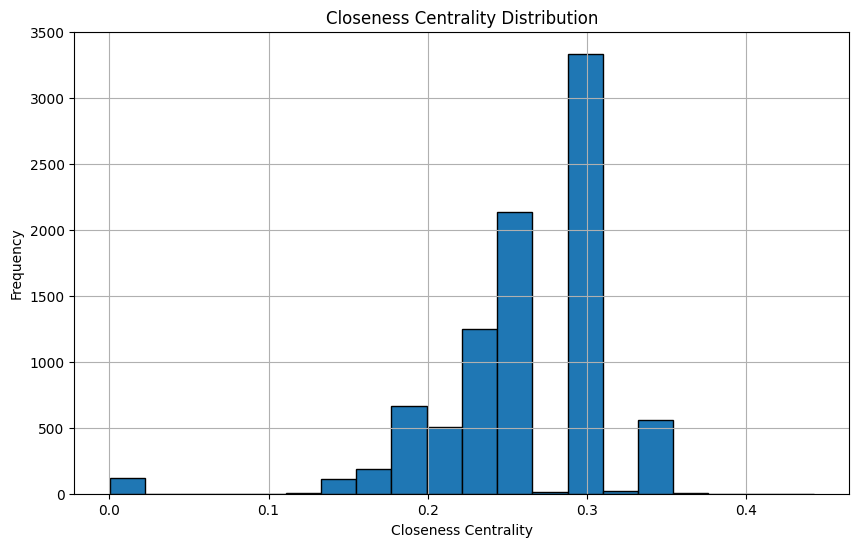

In [15]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Display basic closeness centrality stats
avg_closeness = sum(closeness_centrality.values()) / len(closeness_centrality)
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
max_closeness_value = closeness_centrality[max_closeness_node]

print(f"Average closeness centrality: {avg_closeness:.2f}")
print(f"Node with maximum closeness centrality: {max_closeness_node} (Closeness: {max_closeness_value:.2f})")

# Optionally, visualize the closeness centrality distribution
plt.figure(figsize=(10, 6))
plt.hist(closeness_centrality.values(), bins=20, edgecolor='black')
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Betweenness Centrality

Betweenness centrality is a pivotal metric in social network analysis, particularly in networks like ours, which consist of organizations (few nodes with numerous connections) and individuals (many nodes with fewer connections). This metric quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. It provides insights into the control and influence a node has over the flow of information through the network.

- **Organizations**: Given their high connectivity, organizations might exhibit high betweenness centrality, indicating that they often lie on the shortest paths between other nodes, thereby having the potential to control and influence the flow of information.
- **Individuals**: Depending on their position and connections within the network, individuals might exhibit varied betweenness centrality, reflecting their role in connecting different parts or communities within the network.

Analyzing betweenness centrality allows us to:
- **Identify Gatekeepers**: Nodes with high betweenness centrality can be seen as gatekeepers or brokers of information, connecting disparate parts of the network.
- **Detect Vulnerabilities**: Nodes with high betweenness centrality might be critical for the network’s connectivity and identifying them can spotlight vulnerabilities in the network structure.
- **Understand Information Flow**: Gain insights into how information or influence flows through the network and which nodes control this flow.

In the following code cell, we will calculate and analyze the betweenness centrality of nodes in our network, aiming to identify key gatekeepers and understand the overall structure and vulnerabilities of the network.

Since we see one spike at 0, we know that most nodes in the network don't act as bridges between nodes. This means only a few nodes are bridges.

Average betweenness centrality: 0.00
Node with maximum betweenness centrality: microsoft (Betweenness: 0.72)


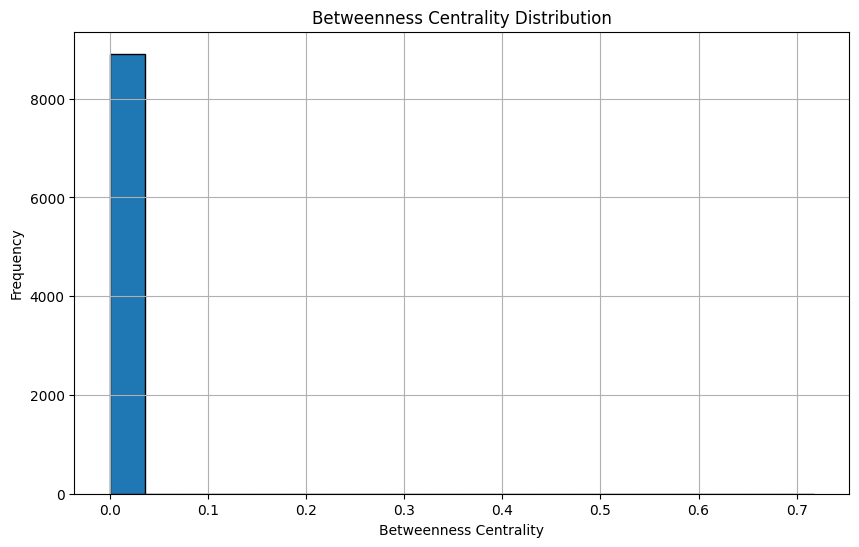

In [16]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Display basic betweenness centrality stats
avg_betweenness = sum(betweenness_centrality.values()) / len(betweenness_centrality)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_betweenness_value = betweenness_centrality[max_betweenness_node]

print(f"Average betweenness centrality: {avg_betweenness:.2f}")
print(f"Node with maximum betweenness centrality: {max_betweenness_node} (Betweenness: {max_betweenness_value:.2f})")

# Optionally, visualize the betweenness centrality distribution
plt.figure(figsize=(10, 6))
plt.hist(betweenness_centrality.values(), bins=20, edgecolor='black')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Clustering Coefficient

The Clustering Coefficient is a metric that describes the degree to which nodes in a network tend to cluster together. In the context of our network, which involves a few organizations connected to numerous individuals, understanding the clustering coefficient can provide insights into the collaborative or interconnected nature of the network.

- **Organizations**: Given their high connectivity, organizations might foster clustering among individuals if the individuals connected to the same organization are also interconnected among themselves.
- **Individuals**: The clustering coefficient for individuals might provide insights into how individuals connected to the same organizations might be interconnected, forming collaborative clusters or communities.

Analyzing the clustering coefficient allows us to:
- **Identify Communities**: High clustering coefficients might indicate the presence of communities or groups of nodes that are tightly interconnected.
- **Understand Collaboration**: Gain insights into how nodes collaborate or form groups within the network, which is crucial for understanding information flow and collective actions.
- **Analyze Network Robustness**: Networks with higher clustering might be more robust to disruptions as they have a denser interconnection among nodes.

In the following code cell, we will calculate and analyze the clustering coefficient of nodes in our network, aiming to identify potential communities and understand the overall collaborative structure of the network.

The resulting clustering coefficient is 0.0 for all nodes because there are no triadic closures (in other words if node A is connected to node B and C, then node B and C are not connected together). This is quite rational since the graph only displays individuals and their connections to organizations, not their intraconnections. 

Average clustering coefficient: 0.00
Node with maximum clustering coefficient: ethereum (Clustering Coefficient: 0.00)


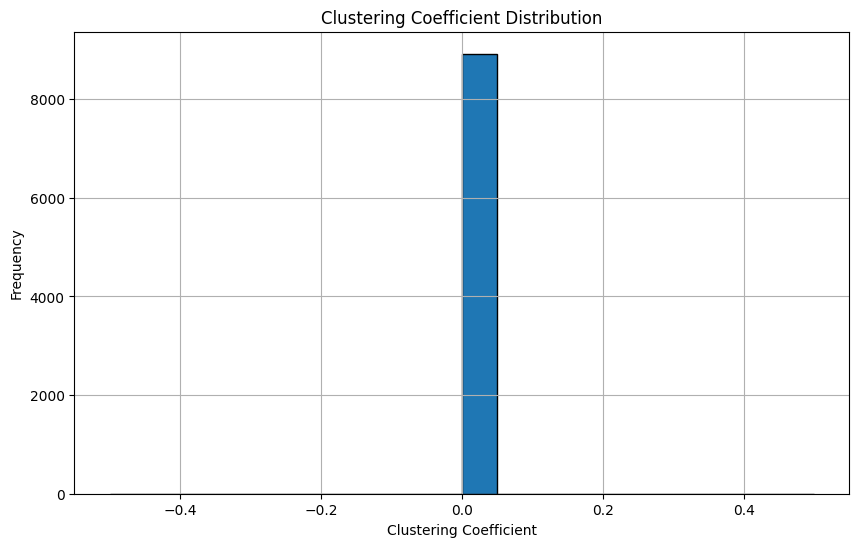

In [18]:
# Calculate the clustering coefficient for each node
clustering_coefficient = nx.clustering(G)

# Display basic clustering coefficient stats
avg_clustering = sum(clustering_coefficient.values()) / len(clustering_coefficient)
max_clustering_node = max(clustering_coefficient, key=clustering_coefficient.get)
max_clustering_value = clustering_coefficient[max_clustering_node]

print(f"Average clustering coefficient: {avg_clustering:.2f}")
print(f"Node with maximum clustering coefficient: {max_clustering_node} (Clustering Coefficient: {max_clustering_value:.2f})")

# Optionally, visualize the clustering coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(clustering_coefficient.values(), bins=20, edgecolor='black')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Additional Analysis: Bipartite Network Projections

Given that our network exhibits a clustering coefficient of 0.0 for all nodes, it suggests a bipartite structure where nodes do not form triads. In such a scenario, it's insightful to explore bipartite network projections, which allow us to investigate indirect relationships and potential communities within each set of nodes (organizations and individuals).

- **Organizations Projection**: This projection will create a network of organizations, where two organizations are connected if they share a common individual.
- **Individuals Projection**: Conversely, this projection will create a network of individuals, where two individuals are connected if they are linked to a common organization.

These projections can provide additional insights into the collaborative structure and potential communities within organizations and individuals, respectively.


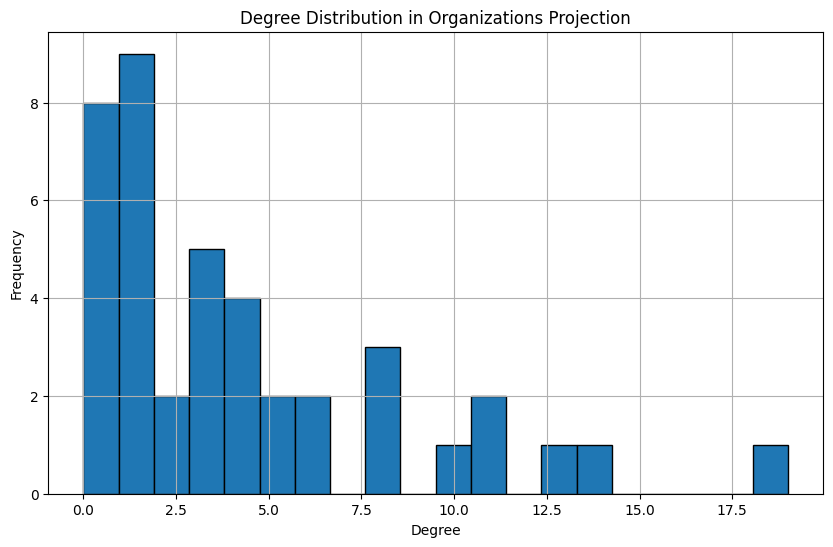

In [19]:
# Identify sets of organizations and individuals
organizations = set(df['Organisation'])
individuals = set(df['member'])

# Create bipartite projections
org_projection = nx.bipartite.projected_graph(G, organizations)
ind_projection = nx.bipartite.projected_graph(G, individuals)

# Optionally, visualize or analyze the projections
# For example, you might explore the degree distribution, connected components, or other relevant metrics within each projection.

# Example: Analyzing Degree Distribution in Organizations Projection
org_degrees = [deg for _, deg in org_projection.degree()]
plt.figure(figsize=(10, 6))
plt.hist(org_degrees, bins=20, edgecolor='black')
plt.title("Degree Distribution in Organizations Projection")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Step 3: Describing network parameters

### Diameter

The Diameter of a network is defined as the longest shortest path between any two nodes in the network. In the context of our bipartite network, where we have a few organizations connected to numerous individuals, understanding the diameter can provide insights into the overall spread and reachability within the network.

- **Organizations**: Given their high connectivity, organizations might be pivotal in minimizing the distance between various individuals in the network.
- **Individuals**: Individuals might be connected to one or more organizations, affecting the overall path lengths within the network.

Analyzing the diameter allows us to:
- **Understand Reachability**: Gain insights into how far apart nodes can be in the network, which is crucial for understanding information dissemination and communication delays.
- **Analyze Network Spread**: Understand the potential spread of information, behaviors, or innovations through the network.
- **Identify Network Limitations**: Recognize limitations in the network’s communication and interaction capabilities.

In the following code cell, we will calculate and analyze the diameter of our network, aiming to understand the overall spread and reachability within the network. Note that calculating the diameter for large networks can be computationally intensive and might require alternative approaches or approximations for very large networks.

The large connected component is the node interconnected organizations, while all the smaller nodes with connections of 2 are the organizations that are disconnected from the rest.

In [20]:
# Check if the graph is connected
is_connected = nx.is_connected(G)

# Calculate and display the diameter
if is_connected:
    network_diameter = nx.diameter(G)
    print(f"The diameter of the network is: {network_diameter}")
else:
    print("The network is not connected, calculating the diameter for each connected component.")

    # Find connected components and their diameters
    connected_components = nx.connected_components(G)
    component_diameters = {i: nx.diameter(G.subgraph(component)) for i, component in enumerate(connected_components)}
    
    # Display the diameter for each connected component
    for component, diameter in component_diameters.items():
        print(f"Diameter of connected component {component}: {diameter}")

The network is not connected, calculating the diameter for each connected component.
Diameter of connected component 0: 12
Diameter of connected component 1: 2
Diameter of connected component 2: 2
Diameter of connected component 3: 2
Diameter of connected component 4: 2
Diameter of connected component 5: 2
Diameter of connected component 6: 2
Diameter of connected component 7: 2
Diameter of connected component 8: 2


### Centralization Scores

Centralization scores in a network provide a measure of the dispersion of all nodes' centrality scores, offering insights into the overall structure and inequality in the distribution of connections or influence within the network. In the context of our bipartite network, which consists of organizations and individuals:

- **Organizations**: A high centralization score might indicate that a few organizations are highly connected or influential, while the rest are not as well connected.
- **Individuals**: Similarly, high centralization among individuals might suggest that a few individuals are connected to multiple organizations, indicating a potential influence or brokerage role within the network.

Understanding centralization allows us to:
- **Identify Key Players**: Nodes that contribute to high centralization might be key players in the network, holding significant influence or control over the network’s flow.
- **Analyze Network Equality**: Low centralization indicates a more equal distribution of connections or influence among nodes, suggesting a more collaborative or democratic network structure.
- **Risk and Vulnerability Assessment**: High centralization might indicate potential vulnerabilities in the network, as the network might be overly dependent on a few nodes.

In the following code cell, we will calculate and analyze the centralization scores of our network, interpreting its implications for network structure, key players, and potential vulnerabilities.

In [22]:
# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G)

# Calculate the centralization score
# Note: NetworkX does not directly provide a function to calculate the centralization of the entire network.
# We will calculate it using the formula: Centralization = (sum(max(C) - C_i) ) / (n-1)(n-2), where C is the centrality score, n is the number of nodes.
max_degree_centrality = max(degree_centrality.values())
centralization_score = sum(max_degree_centrality - c for c in degree_centrality.values()) / ((len(G.nodes())-1)*(len(G.nodes())-2))

# Display the centralization score
print(f"The centralization score of the network is: {centralization_score:.2f}")


The centralization score of the network is: 0.00


### Cliques within the Network

Cliques are fully connected subgraphs within a network, meaning that every node within the clique is connected to every other node in the clique. In the context of our bipartite network, which consists of organizations and individuals:

- **Organizations**: A clique might represent a group of organizations that are all directly connected to the same set of individuals, indicating a potential collaboration or shared membership.
- **Individuals**: Similarly, a clique of individuals might indicate a group of people who are all members of the same set of organizations, suggesting a common interest or affiliation.

Understanding cliques allows us to:
- **Identify Subgroups**: Cliques can help identify tightly-knit subgroups within the network, which might be collaborating or sharing resources.
- **Analyze Network Structure**: Understanding the size and number of cliques can provide insights into the network’s overall structure and the existence of sub-communities.
- **Collaboration and Competition**: Identifying cliques can also highlight potential areas of collaboration or competition within the network.

In the following code cell, we will identify and analyze the cliques within our network, interpreting their implications for network structure, collaboration, and competition.

Total number of cliques found: 9629
Maximum clique size: 2
Minimum clique size: 2
Average clique size: 2.00


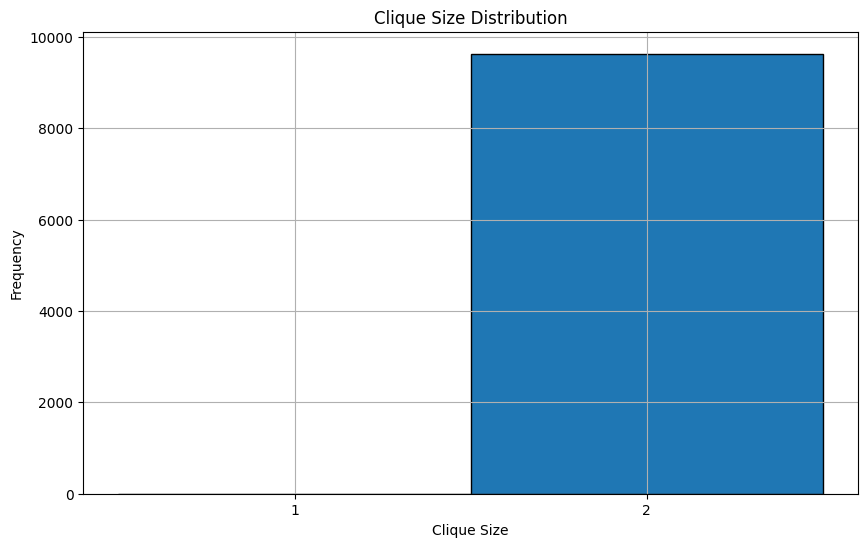

In [23]:
# Identify cliques within the network
# Note: NetworkX provides a function to find cliques, but it's designed for undirected graphs. Ensure your graph is suitable or convert it if necessary.

# Find all cliques in the network
cliques = list(nx.find_cliques(G))

# Display the number of cliques found
print(f"Total number of cliques found: {len(cliques)}")

# Optionally, analyze and visualize the size distribution of the cliques
clique_sizes = [len(clique) for clique in cliques]

# Display some basic statistics about the clique sizes
print(f"Maximum clique size: {max(clique_sizes)}")
print(f"Minimum clique size: {min(clique_sizes)}")
print(f"Average clique size: {sum(clique_sizes) / len(clique_sizes):.2f}")

# Visualize the distribution of clique sizes
plt.figure(figsize=(10, 6))
plt.hist(clique_sizes, bins=range(1, max(clique_sizes) + 2), edgecolor='black', align='left')
plt.title("Clique Size Distribution")
plt.xlabel("Clique Size")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(range(1, max(clique_sizes) + 1))
plt.show()

### Analysis of Cliques of Size 2

Given that all identified cliques are of size 2, this suggests a pattern of dyadic relationships within the network, where organizations and individuals are paired in isolated connections without forming larger, fully-connected subgroups. In the context of our bipartite network:

- **Organizations and Individuals**: Each pair (a clique of size 2) represents a direct connection between an organization and an individual, without involving larger interconnected groups.
  
Understanding these dyadic cliques allows us to:
- **Analyze Pairwise Relationships**: The existence of cliques of size 2 indicates that the network may be characterized by direct, pairwise relationships between organizations and individuals.
- **Identify Lack of Larger Collaborations**: The absence of larger cliques suggests that there aren’t larger, fully interconnected subgroups of organizations or individuals within the network.
- **Strategy and Network Development**: Recognizing these dyadic relationships might inform strategies for developing the network, such as fostering connections to build larger, interconnected subgroups.

In the following code cell, we will further explore these cliques of size 2, potentially identifying patterns or key nodes within these dyadic relationships.

Top 10 nodes with the highest occurrences in cliques:
1. Node: microsoft, Occurrences: 3916
2. Node: Azure, Occurrences: 1616
3. Node: apache, Occurrences: 1074
4. Node: google, Occurrences: 802
5. Node: nodejs, Occurrences: 363
6. Node: elastic, Occurrences: 169
7. Node: aws, Occurrences: 168
8. Node: reactjs, Occurrences: 138
9. Node: python, Occurrences: 118
10. Node: facebook, Occurrences: 107


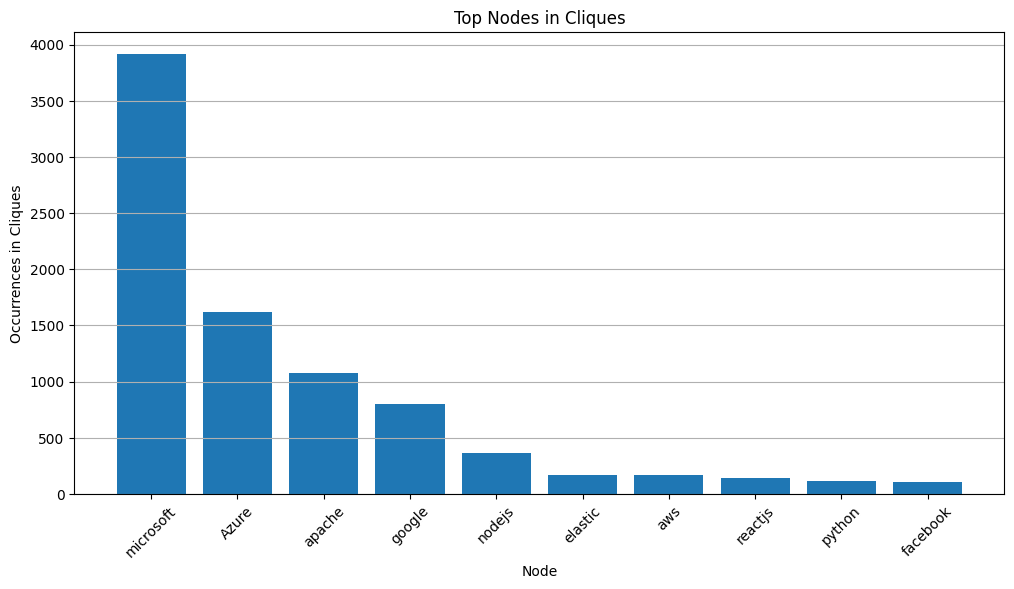

In [24]:
# Since all cliques are of size 2, we might want to explore these pairs further.
# For example, we might want to identify nodes that appear most frequently in these cliques, indicating their higher connectivity or importance in the network.

# Flatten the list of cliques and count the occurrence of each node
from collections import Counter
node_occurrences = Counter(node for clique in cliques for node in clique)

# Display the top 10 nodes with the highest occurrences in cliques
top_nodes = node_occurrences.most_common(10)

# Display the top nodes
print("Top 10 nodes with the highest occurrences in cliques:")
for i, (node, count) in enumerate(top_nodes):
    print(f"{i+1}. Node: {node}, Occurrences: {count}")

# Optionally, visualize the top nodes and their occurrences in cliques
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_nodes)), [count for node, count in top_nodes], tick_label=[node for node, count in top_nodes])
plt.title("Top Nodes in Cliques")
plt.xlabel("Node")
plt.ylabel("Occurrences in Cliques")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Clustering Coefficient

The Clustering Coefficient is a measure that provides insights into the degree to which nodes in a network tend to cluster together. It is defined as the proportion of a node's neighbors that are also neighbors with each other. In the context of our bipartite network:

- **Organizations and Individuals**: The clustering coefficient may reveal how individuals (or organizations) tend to be grouped or clustered around particular organizations (or individuals).

Given that our network is bipartite (consisting of two types of nodes: organizations and individuals), traditional clustering coefficients may not provide meaningful insights due to the nature of connections (organizations are only directly connected to individuals, not to other organizations, and vice versa). However, exploring the clustering coefficient in the projected graphs (e.g., a graph projecting only organizations, where two organizations are connected if they share a common member) could yield informative results.

In the following code cell, we will calculate the clustering coefficient for the network and discuss its implications in the context of our organizational and individual nodes.

**Note**: Because of the size of the network an approximation is used when calculating the avarage_clustering. `nx.average_clustering` becomes `approx.average_clustering`

*Remember that the results are for biparte projection of the graph*

The relatively lower clustering coefficient for organizations suggests that while there are some clusters of organizations that share members, there are also many organizations that do not share members with other organizations. This could indicate a level of exclusivity or specialization in some organizations.

The very high clustering coefficient for individuals suggests that the individuals in this network tend to belong to tightly-knit groups or communities. This could imply that if an individual is a member of two organizations, other members of those organizations are also likely to be connected to each other, forming a closely connected group.


In [27]:
import networkx.algorithms.bipartite as bipartite
import networkx.algorithms.approximation as approx

# Assuming df is your DataFrame and it has been cleaned of "None" and NaN values
# and G is your graph

# Add 'bipartite' attribute to nodes
for organization in df['Organisation'].unique():
    G.nodes[organization]['bipartite'] = 0  # organization
    
for member in df['member'].unique():
    G.nodes[member]['bipartite'] = 1  # member

# Separate the sets of nodes (organizations and individuals)
org_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
ind_nodes = set(G) - org_nodes

# Projected Graphs
org_projected_graph = bipartite.projected_graph(G, org_nodes)
ind_projected_graph = bipartite.projected_graph(G, ind_nodes)

# Calculate the approximate clustering coefficient for both projected graphs
org_clustering_coefficient = approx.average_clustering(org_projected_graph, trials=1000)  # adjust trials as needed
ind_clustering_coefficient = approx.average_clustering(ind_projected_graph, trials=1000)  # adjust trials as needed

# Display the clustering coefficients
print(f"Approximate Average Clustering Coefficient (Organizations): {org_clustering_coefficient:.4f}")
print(f"Approximate Average Clustering Coefficient (Individuals): {ind_clustering_coefficient:.4f}")

# Note: Interpretation of these values should consider the bipartite nature of the original network and the meaning of connections in the projected graphs.

Approximate Average Clustering Coefficient (Organizations): 0.2820
Approximate Average Clustering Coefficient (Individuals): 0.9830


## Modularity

Modularity is a metric that quantifies the strength of division of a network into modules, also known as communities. Networks with high modularity have dense connections between the nodes within modules and sparse connections between nodes in different modules. In the context of our network, a high modularity would indicate that the members (individuals) and organizations tend to form communities where members are more likely to be connected to organizations within the same community than to organizations in other communities. Calculating modularity can provide insights into the community structure of the network and help identify how individuals and organizations cluster together.

**Modularity**: The modularity value ranges from -1 to 1, where a value close to 1 indicates a strong community structure.

**Visualization**: The visualization will show the nodes colored according to their community. This can give you a visual sense of how well the network breaks down into communities.

**Community Detection**: The Louvain method is used here for community detection and to calculate modularity. It is widely used due to its accuracy and efficiency.

/run/user/1000/ipykernel_445/1562121297.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


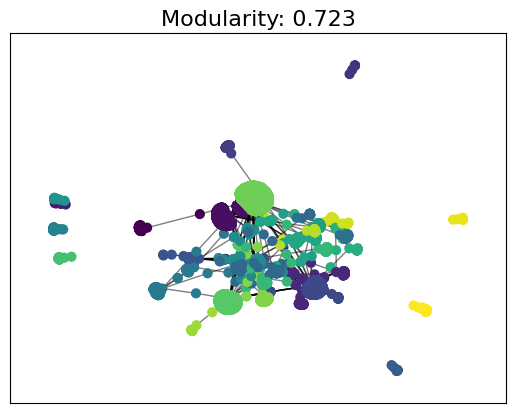

Modularity: 0.723


In [29]:
import community as community_louvain
import matplotlib.cm as cm

# Compute the best partition using Louvain method
partition = community_louvain.best_partition(G)

# Compute modularity
modularity = community_louvain.modularity(partition, G)

# Visualize the communities
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Modularity: {modularity:.3f}", fontsize=16)
plt.show()

# Display modularity
print(f"Modularity: {modularity:.3f}")